## Install and import libs

Após a instalação reinicie o runtime

In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=2e62db50cc597b04d87307a07ccd75066936d0f4f588fc402ae063709f94b77a
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [ ]:
!pip install -U networkx

In [ ]:
!pip install nxviz==0.6.3

In [ ]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import networkx as nx
import nxviz
import matplotlib.patches as mpatches
from nxviz.plots import CircosPlot

In [ ]:
import warnings

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
nx.__version__

'3.1'

## Step 0 | Data Processing

In [ ]:
class Pipeline:
    def __init__(self):
        self.tasks = []

    def task(self, depends_on=None):
        idx = 0
        if depends_on:
            idx = self.tasks.index(depends_on) + 1
        def inner(f):
            self.tasks.insert(idx, f)
            return f
        return inner

    def run(self, input_):
        output = input_
        for task in self.tasks:
            output = task(output)
        return output

pipeline = Pipeline()

In [ ]:
#https://en.wikipedia.org/wiki/Complex_network
#https://en.wikipedia.org/wiki/Graph
@pipeline.task()
def build_graph(page_title: str):

    SEED = page_title.title()
    STOPS = ("International Standard Serial Number",
            "International Standard Book Number",
            "National Diet Library",
            "International Standard Name Identifier",
            "International Standard Book Number (Identifier)",
            "Pubmed Identifier",
            "Pubmed Central",
            "Digital Object Identifier",
            "Arxiv",
            "Proc Natl Acad Sci Usa",
            "Bibcode",
            "Library Of Congress Control Number",
            "Jstor",
            "Doi (Identifier)",
            "Isbn (Identifier)",
            "Pmid (Identifier)",
            "Arxiv (Identifier)",
            "Bibcode (Identifier)")

    todo_lst = [(0, SEED)]
    todo_set = set(SEED)
    done_set = set()

    g = nx.DiGraph()
    layer, page = todo_lst[0]


    while layer < 2:

        del todo_lst[0]
        done_set.add(page)

        #print(layer, page)

        try:
            wiki = wikipedia.page(page)
        except:
            print("Could not load", page)
            layer, page = todo_lst[0]
            continue

        for link in wiki.links:
            link = link.title()
            if link not in STOPS and not link.startswith("List Of"):
                if link not in todo_set and link not in done_set:
                    todo_lst.append((layer + 1, link))
                    todo_set.add(link)
                g.add_edge(page, link)
        layer, page = todo_lst[0]

    return g

Remoção de duplicatas

In [ ]:
@pipeline.task(depends_on=build_graph)
def remote_duplicates(g):
    g = g.reverse()  # Inverte as direções das arestas
    g = nx.DiGraph(list(g.edges()))  # Converte o grafo em uma lista de arestas
    g = nx.DiGraph(set(g.edges()))  # Converte a lista de arestas em um conjunto para remover duplicatas
    return g

In [ ]:
@pipeline.task(depends_on=remote_duplicates)
def print_analyzes(g):
    print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))
    print("Is weakly connected? ", nx.is_weakly_connected(g))
    print("Is strongly connected? ", nx.is_strongly_connected(g))
    return g

In [ ]:
@pipeline.task(depends_on=print_analyzes)
def get_gcc(g):
    # Obtém os componentes fortemente conectados
    strong_components = nx.strongly_connected_components(g)

    # Encontra o maior componente
    largest_component = max(strong_components, key=len)

    # Cria um subgrafo apenas com o maior componente
    Gcc = g.subgraph(largest_component)
    return Gcc

In [ ]:
Gcc = pipeline.run("graph")

Could not load Dyne
Could not load Erg
Could not load Gram (Disambiguation)
Could not load Gramme (Disambiguation)
Could not load Metre Convention
Could not load Oersted
Could not load Orders Of Magnitude (Mass)
Could not load Penny (United States Coin)
Could not load Planck Constant
Could not load Poise (Unit)
Could not load Qes
Could not load Troy Ounce
Could not load Water
Could not load Weight Scale
11458 nodes, 17787 edges
Is weakly connected?  True
Is strongly connected?  False


Número de Nodes e Links do GCC

In [ ]:
len(Gcc.nodes),len(Gcc.edges())

(47, 757)

## Step 1 | Eccentricity, Periphery, Radius, Center and Diameter

Calculando a melhor posição dos Nodes no plot

In [ ]:
pos = nx.spring_layout(Gcc,seed=123456789)

A cor dele baseada na Exccentricity

In [ ]:
color = list(dict(nx.eccentricity(Gcc)).values())

Os objetos demoram para processar, por via das dúvidas, use o Joblib e salve como pkl

In [ ]:
joblib.dump(pos, 'pos.pkl')

['pos.pkl']

In [ ]:
joblib.dump(color, 'color.pkl')

['color.pkl']

In [ ]:
nx.write_graphml(Gcc, "Gcc.graphml")

Exporte como Graphml ou como pkl

In [ ]:
#joblib.dump(Gcc, 'Gcc.pkl')

In [ ]:
#Gcc = nx.read_graphml("Gcc.graphml")

Se precisar ler de novo

In [ ]:
#pos = joblib.load('pos.pkl', mmap_mode='r')

In [ ]:
#color = joblib.load('color.pkl', mmap_mode='r')

In [ ]:
#Gcc = joblib.load('Gcc.pkl', mmap_mode='r')

In [ ]:
#Gcc = nx.read_graphml("Gcc.graphml")

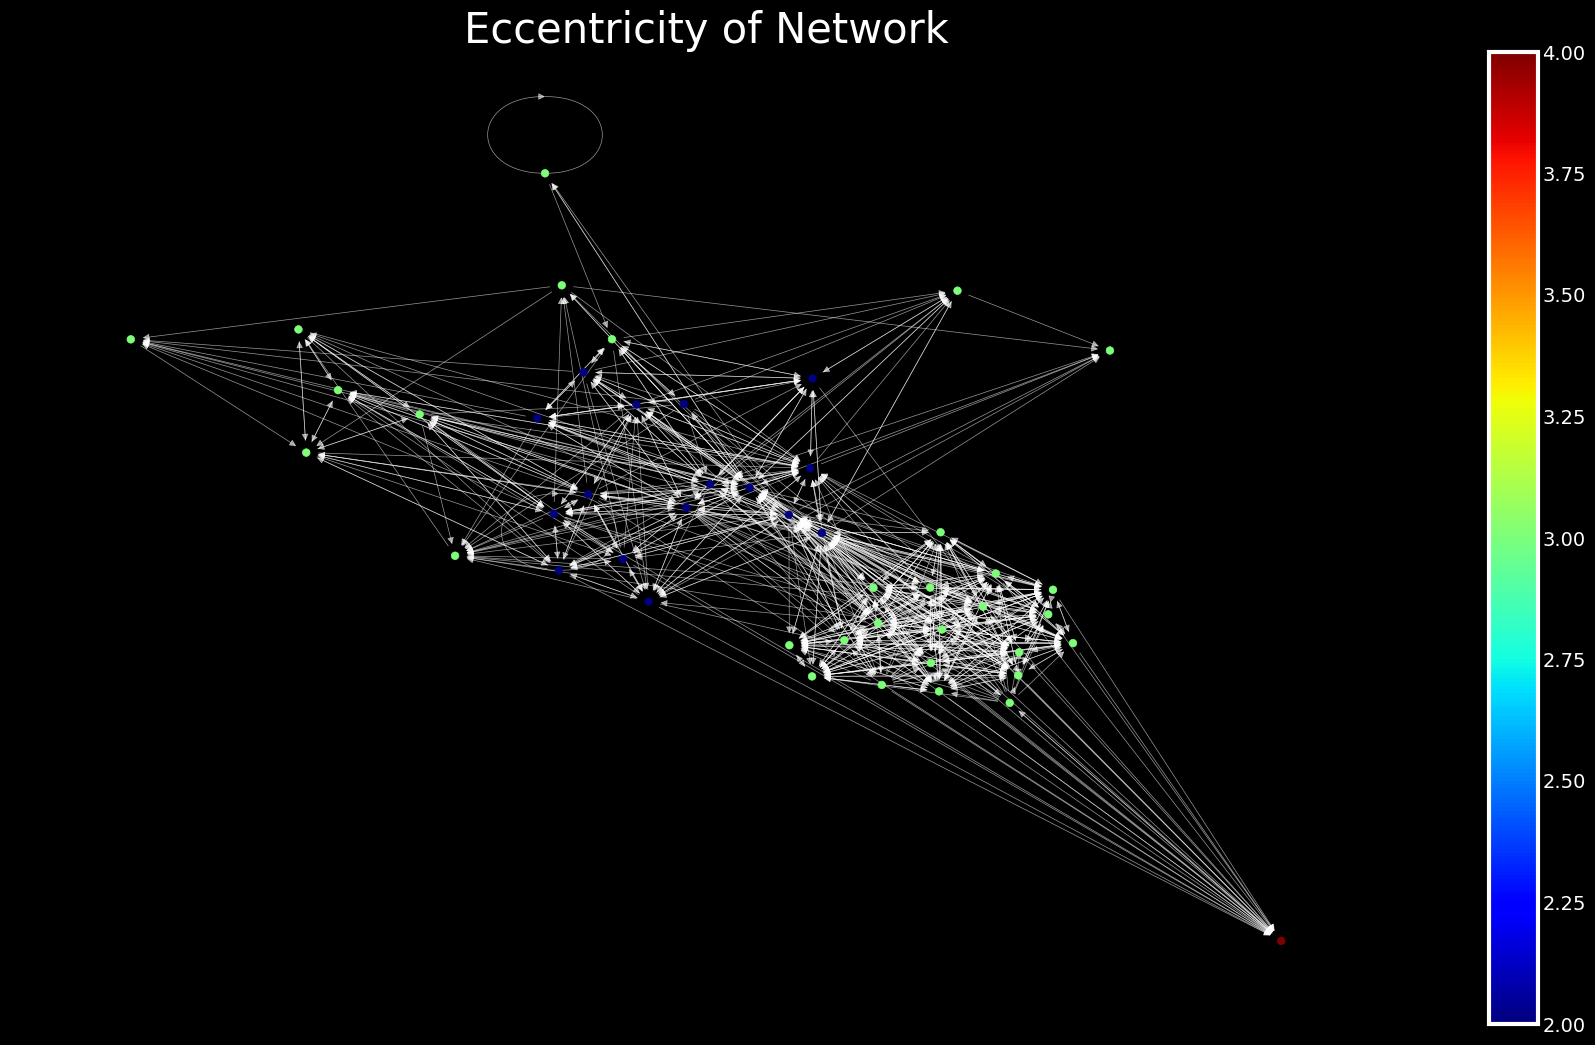

In [ ]:
plt.style.use("dark_background")

#plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

fig, ax = plt.subplots(1,1,figsize=(20,12))
# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.5,
                       alpha=0.6,
                       ax=ax,
                       edge_color='white')

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)

# draw labels
#nx.draw_networkx_labels(Gcc, pos=pos,
#                        font_color='white', ax=ax)

plt.title("Eccentricity of Network", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.savefig('eccentricity.jpg',dpi=300)
plt.show()

Na figura acima vemos o plot do nosso GCC. Os Nodes (artistas) estão classificados pela métrica Eccentricity. A Eccentricity é a distância máxima de um Node a todos outros de uma network. A variação na GCC vai desde uma distância de 3 Nodes à uma máxima distância de 6 Nodes

O Diameter é o máximo valor de Eccentricity de uma network. Como vimos no plot esse valor é 4. Podemos confirmar esse valor usando o NetworkX

In [ ]:
print("Diameter of network (Gcc): {}".format(nx.diameter(Gcc)))

Diameter of network (Gcc): 4


Periphery é o conjunto de todos os Nodes que possuem cujo a Eccentricity é igual ao Diameter.

In [ ]:
nx.periphery(Gcc)

['Cgs Unit']

Radius é o menor valor de Excentricity de uma network. Como vimos no plot esse valor é 2. No NetworkX podemos achar usando

In [ ]:
print("Radius of network(Gcc): {}".format(nx.radius(Gcc)))

Radius of network(Gcc): 2


Center é o conjunto de todos os Nodes que possuem a Exccentricity igual ao Radius

In [ ]:
nx.center(Gcc)

['Centimetre–Gram–Second System Of Units',
 '2019 Redefinition Of The Si Base Units',
 'Second',
 'International Bureau Of Weights And Measures',
 'Imperial Units',
 'Kilogram',
 'United States Customary Units',
 'Metre',
 'Mks System Of Units',
 'System Of Measurement',
 'Conversion Of Units',
 'Si Base Unit',
 'Chinese Units Of Measurement',
 'Celsius',
 'International System Of Units',
 'Units Of Measurement In France Before The French Revolution']

## Step 2 | Centrality Distribution: Bivariate Analysis


### 2.1 Degree

Degree é o número de conexões de um Nó. Os Nodes que possuem os maiores valores de Degree são conhecidos como Hubs (principais Nodes). Vamos ver o top 20 Nodes com maior Degree

In [ ]:
i=0
for k, v in sorted(dict(nx.degree(Gcc)).items(), key=lambda x: x[1],reverse=True):
  print(k,v)
  if i == 20:
    break
  i+=1

International System Of Units 68
Second 64
Centimetre–Gram–Second System Of Units 59
Centimetre 49
System Of Measurement 49
Gal (Unit) 45
Kilogram 45
Statampere 44
Maxwell (Unit) 44
Gauss (Unit) 43
Abampere 43
Abcoulomb 43
Abohm 42
Statvolt 42
Barye 42
Abvolt 42
Abhenry 40
Statohm 40
Stilb (Unit) 39
Gilbert (Unit) 38
Abmho 37


Cores conforme o Degree de um Node

In [ ]:
color_degree = list(dict(nx.degree(Gcc)).values())

In [ ]:
joblib.dump(color_degree, 'color_degree.pkl')

['color_degree.pkl']

In [ ]:
color_degree = joblib.load('color_degree.pkl', mmap_mode='r')

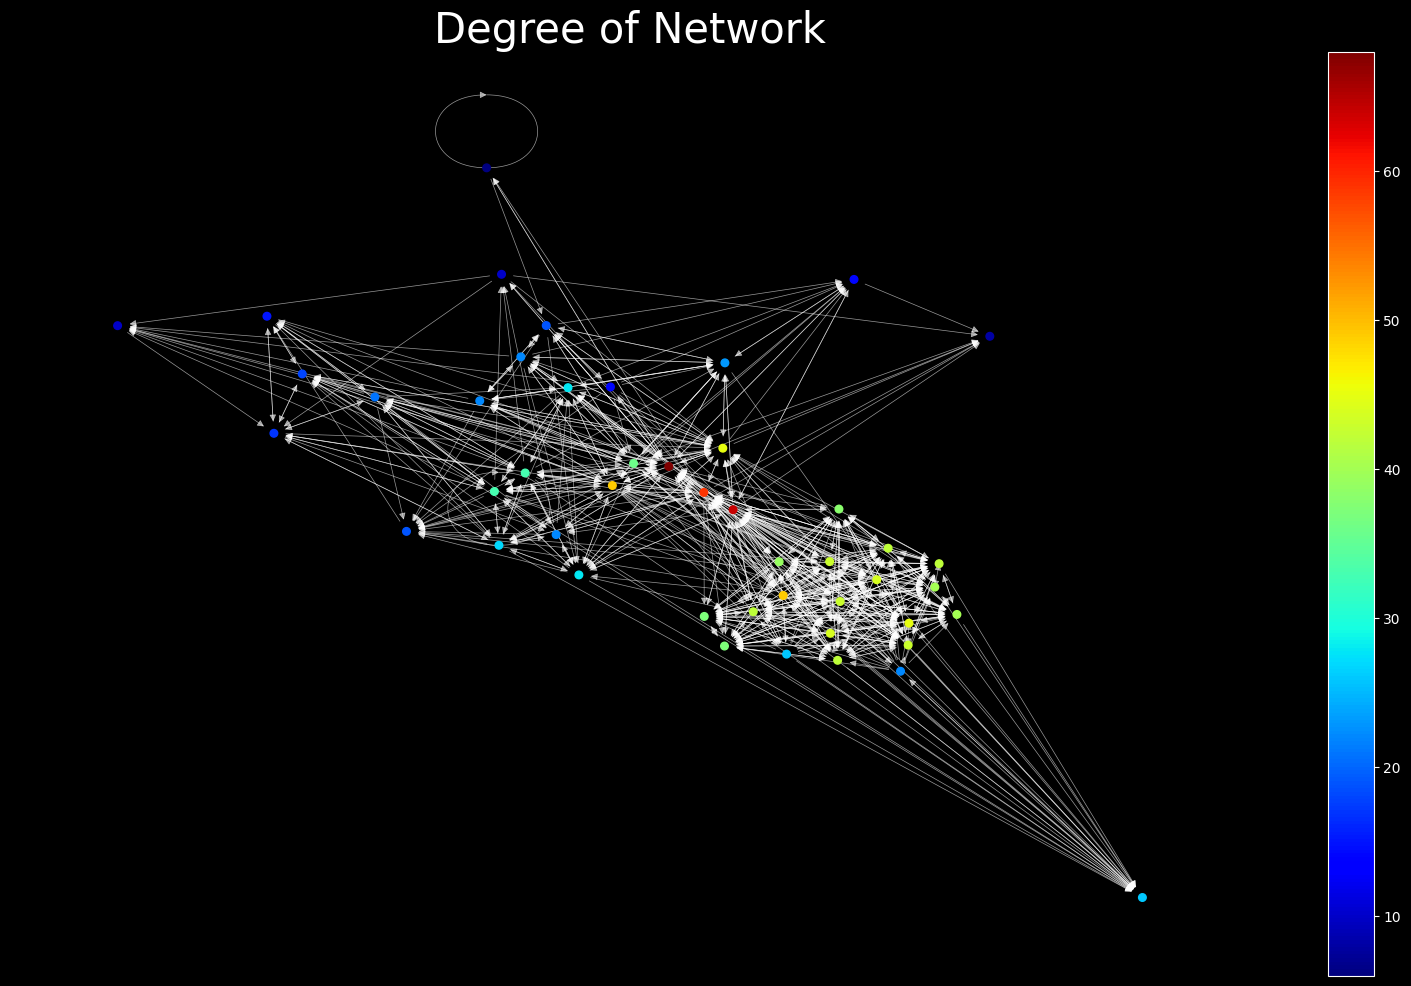

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

# the degree of network(Gcc)
fig, ax = plt.subplots(1,1,figsize=(20,12))

# layout position
#pos = nx.spring_layout(g,seed=123456789)

# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.5,
                       alpha=0.6,
                       ax=ax,
                       edge_color='white')

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_degree,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)

# draw labels
#nx.draw_networkx_labels(Gcc, pos=pos,
#                        font_color='white', ax=ax)

plt.title("Degree of Network", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.savefig('degree.jpg', dpi=300)
plt.show()

O plot nos diz que a maioria dos Nodes possuem até 25 Degrees. Por existir alguns Nodes com valor alto, cerca de 70, acabou enviesando o plot. Vamos conferir numa Probability Dense Function (PDF) a distribuição dos Degrees da network

### 2.2 Probability Dense Function (PDF)

Agora temos uma real visualização de como está distribuindo o Degree da rede, sendo que a maioria dos nós estão concentrados em até 40 vizinhos/conexões. É possível também visualizar no lado direito do gráfico a probabilidade de haver um Node com esse número de vizinhos

In [ ]:
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

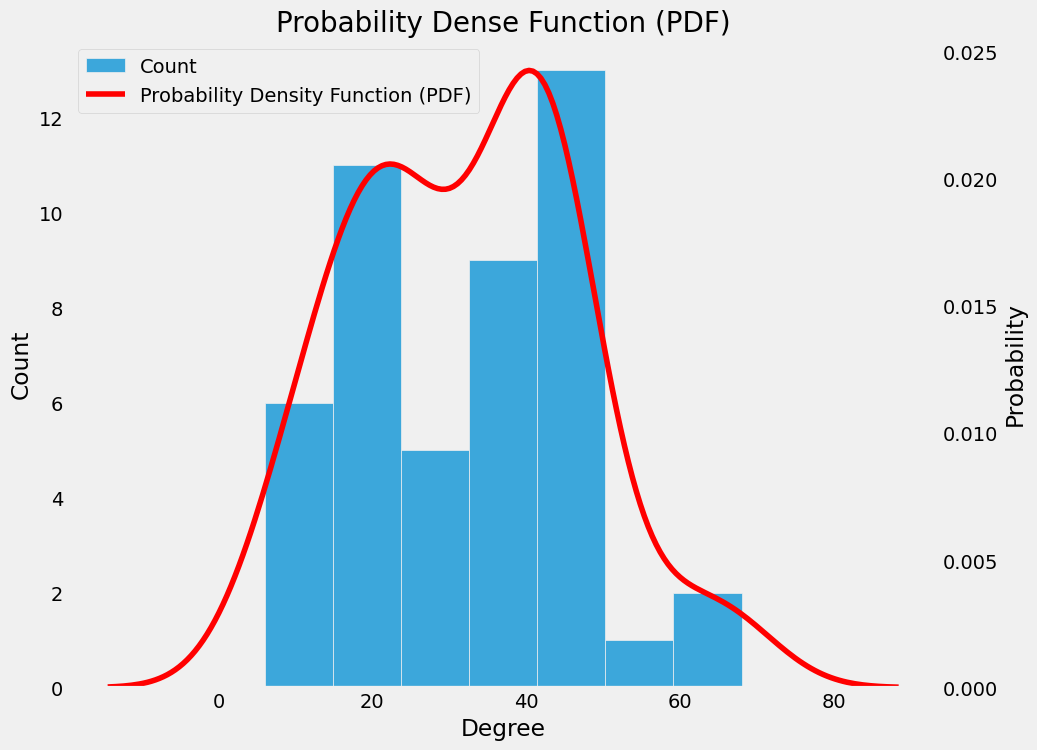

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.histplot(color_degree,label="Count",ax=ax,bins=7)
ax2 = ax.twinx()
sns.kdeplot(color_degree,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")
plt.title("Probability Dense Function (PDF)", fontsize = 20)
plt.savefig('probability_density_function.jpg', dpi=300,bbox_inches="tight")
plt.show()

### 2.3 Cumaltive Dense Function (CDF)

Podemos ter uma visualização similar considerando uma Cumaltive Dense Function (CDF). A CDF permite ver a porcentagem de Degree na forma acumulada. Vemos que cerca de 86% dos artistas tem Degree 40 ou menor

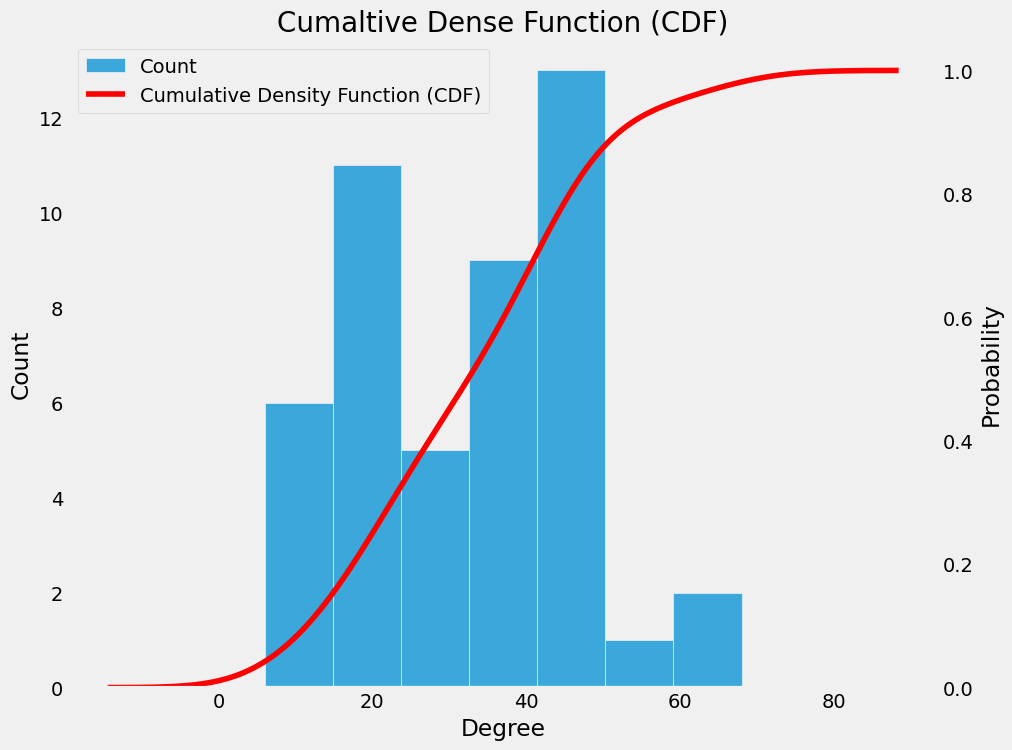

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(color_degree,label="Count",ax=ax,bins=7)
ax2 = ax.twinx()
sns.kdeplot(color_degree,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")
plt.title("Cumaltive Dense Function (CDF)", fontsize = 20)
plt.savefig("cumulative_density_function.jpg",dpi=300,bbox_inches="tight")
plt.show()

Outra possibilidade de visualização da CDF é na escala logarítmica. O uso da escala logarítmica é eficiente quando temos uma escala de grandeza. Visualizar em log permite comparar com outras redes mesmo que menores graças ao uso de ordem grandeza. **(ALTERAR)**

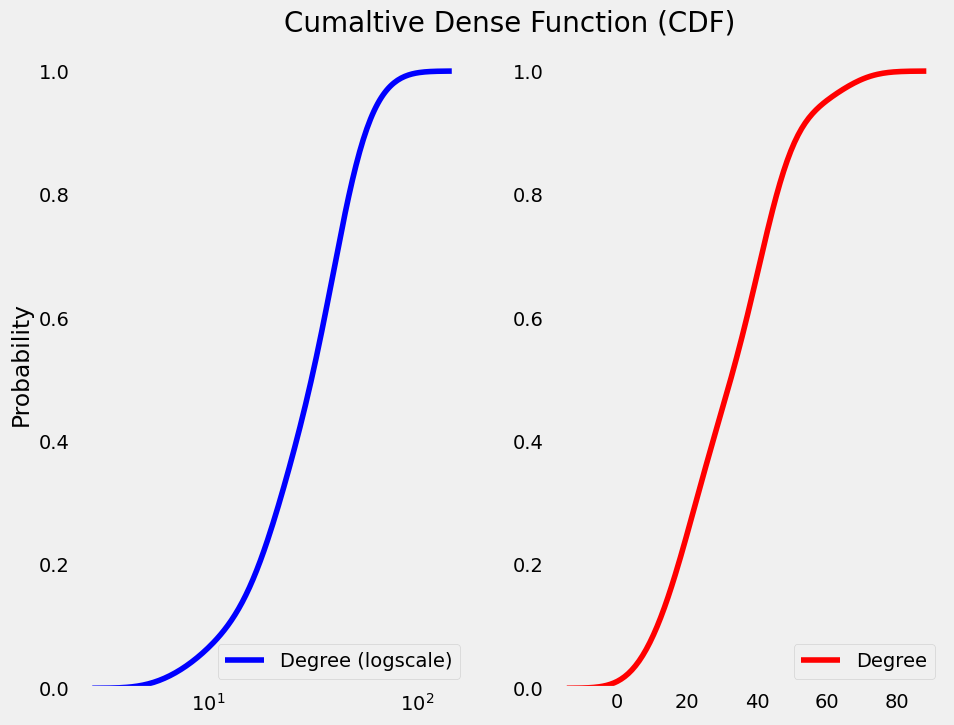

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,2,figsize=(10,8))

sns.kdeplot(color_degree,color='b',label="Degree (logscale)",ax=ax[0],cumulative=True,log_scale=True)
ax[0].grid(False)
ax[0].legend(loc="lower right")
ax[0].set_ylabel("Probability")

sns.kdeplot(color_degree,color='r',label="Degree",ax=ax[1],cumulative=True,log_scale=False)
ax[1].grid(False)
ax[1].set_ylabel("")
ax[1].legend(loc="lower right")

plt.title("Cumaltive Dense Function (CDF)", fontsize = 20, x=-0.1, y=1.0)
plt.savefig('comparative_cdf_log.jpg', dpi=300,bbox_inches="tight")
plt.show()

## Step 3 | Node Ranking: Degree, Closeness, Betweenness and Eigenvector Centrality

### 3.1 Degree Centrality

In [ ]:
# color of nodes
color_degree_centrality = list(dict(nx.degree_centrality(Gcc)).values())

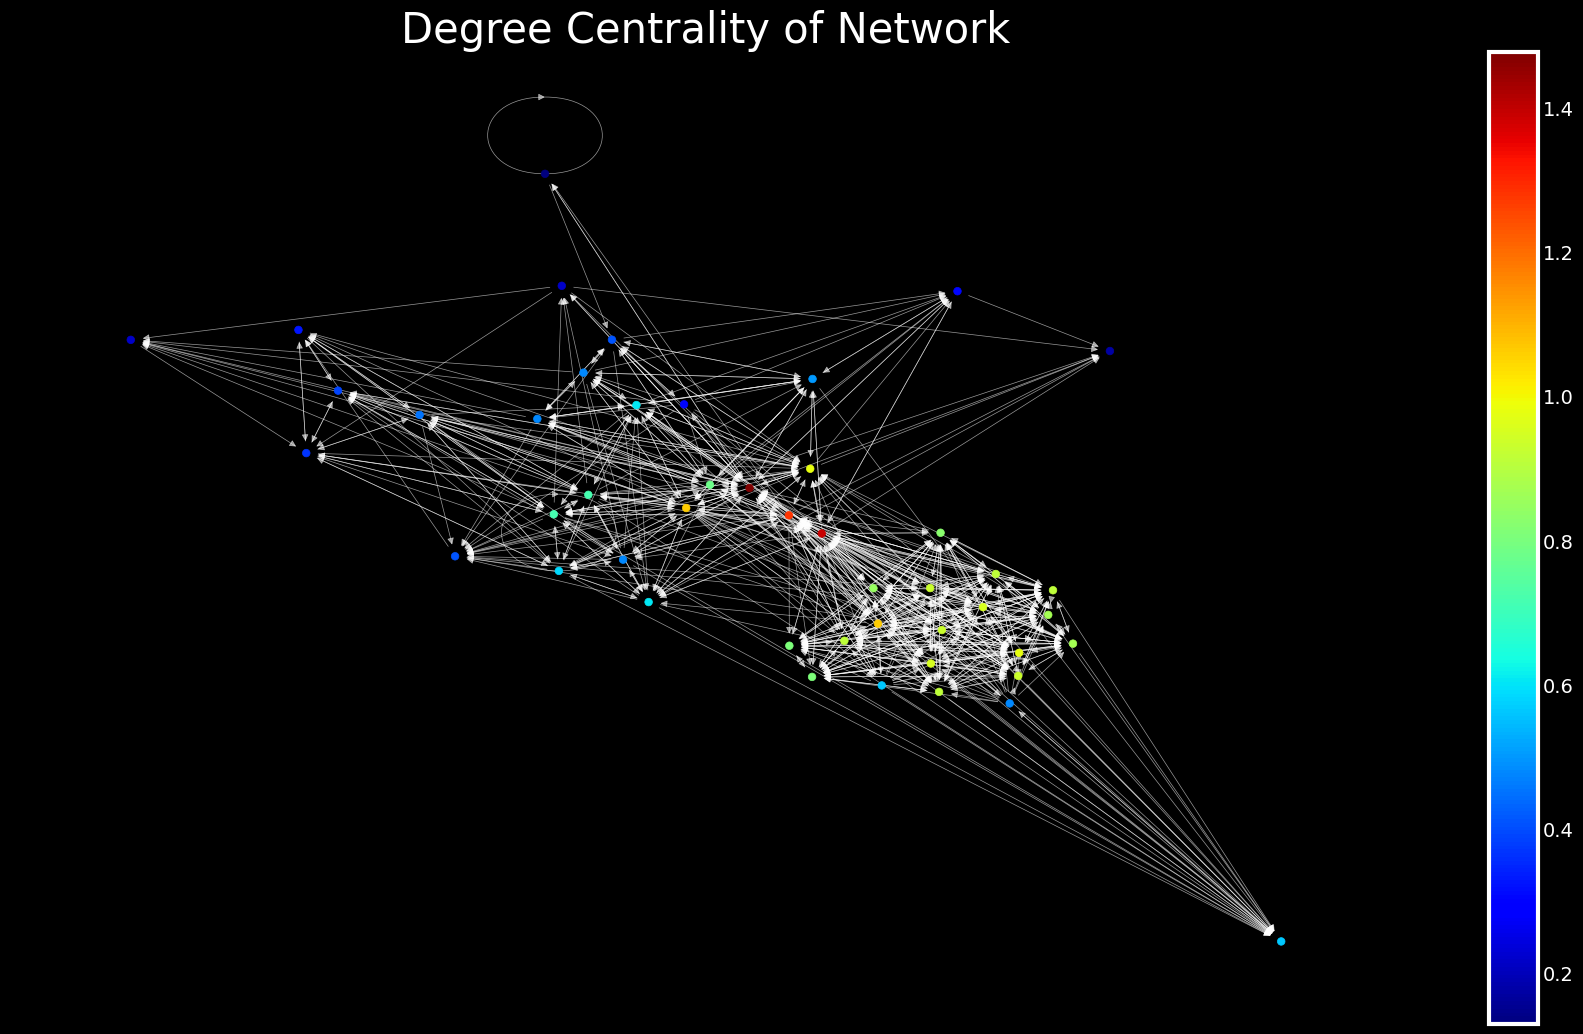

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

COLOR = 'white'
plt.rcParams['text.color'] = COLOR

# the degree centrality of network(Gcc)
fig, ax = plt.subplots(1,1,figsize=(20,12))

#layout position
#pos = nx.spring_layout(g,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.5,
                       alpha=0.6,
                       ax=ax,
                       edge_color='white')
# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_degree_centrality,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)

# draw labels
#nx.draw_networkx_labels(g, pos=pos,
#                        font_color='white', ax=ax)

plt.title("Degree Centrality of Network", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.savefig('degree_centrality.jpg',dpi=300)
plt.show()

Degree Centrality é o número de conexões de um Node, a idéia é similar ao Degree. Muda o cálculo.

Degree Centrality é o Grau do Node dividido pelo número de Nodes - 1

De forma similar, temos o top 20 de Degree Centrality

In [ ]:
i=0
for k, v in sorted(nx.degree_centrality(Gcc).items(), key=lambda x: x[1],reverse=True):
  print(k,v)
  if i == 20:
    break
  i+=1

International System Of Units 1.4782608695652173
Second 1.391304347826087
Centimetre–Gram–Second System Of Units 1.2826086956521738
Centimetre 1.065217391304348
System Of Measurement 1.065217391304348
Gal (Unit) 0.9782608695652174
Kilogram 0.9782608695652174
Statampere 0.9565217391304348
Maxwell (Unit) 0.9565217391304348
Gauss (Unit) 0.9347826086956521
Abampere 0.9347826086956521
Abcoulomb 0.9347826086956521
Abohm 0.9130434782608695
Statvolt 0.9130434782608695
Barye 0.9130434782608695
Abvolt 0.9130434782608695
Abhenry 0.8695652173913043
Statohm 0.8695652173913043
Stilb (Unit) 0.8478260869565217
Gilbert (Unit) 0.8260869565217391
Abmho 0.8043478260869565


### 3.2 Closeness Centrality

In [ ]:
# color of nodes
color_closeness_centrality = list(dict(nx.closeness_centrality(Gcc)).values())

In [ ]:
#joblib.dump(color_closeness_centrality, 'color_closeness_centrality.pkl')
#color_closeness_centrality

In [ ]:
#color_closeness_centrality = joblib.load('color_closeness_centrality.pkl', mmap_mode='r')

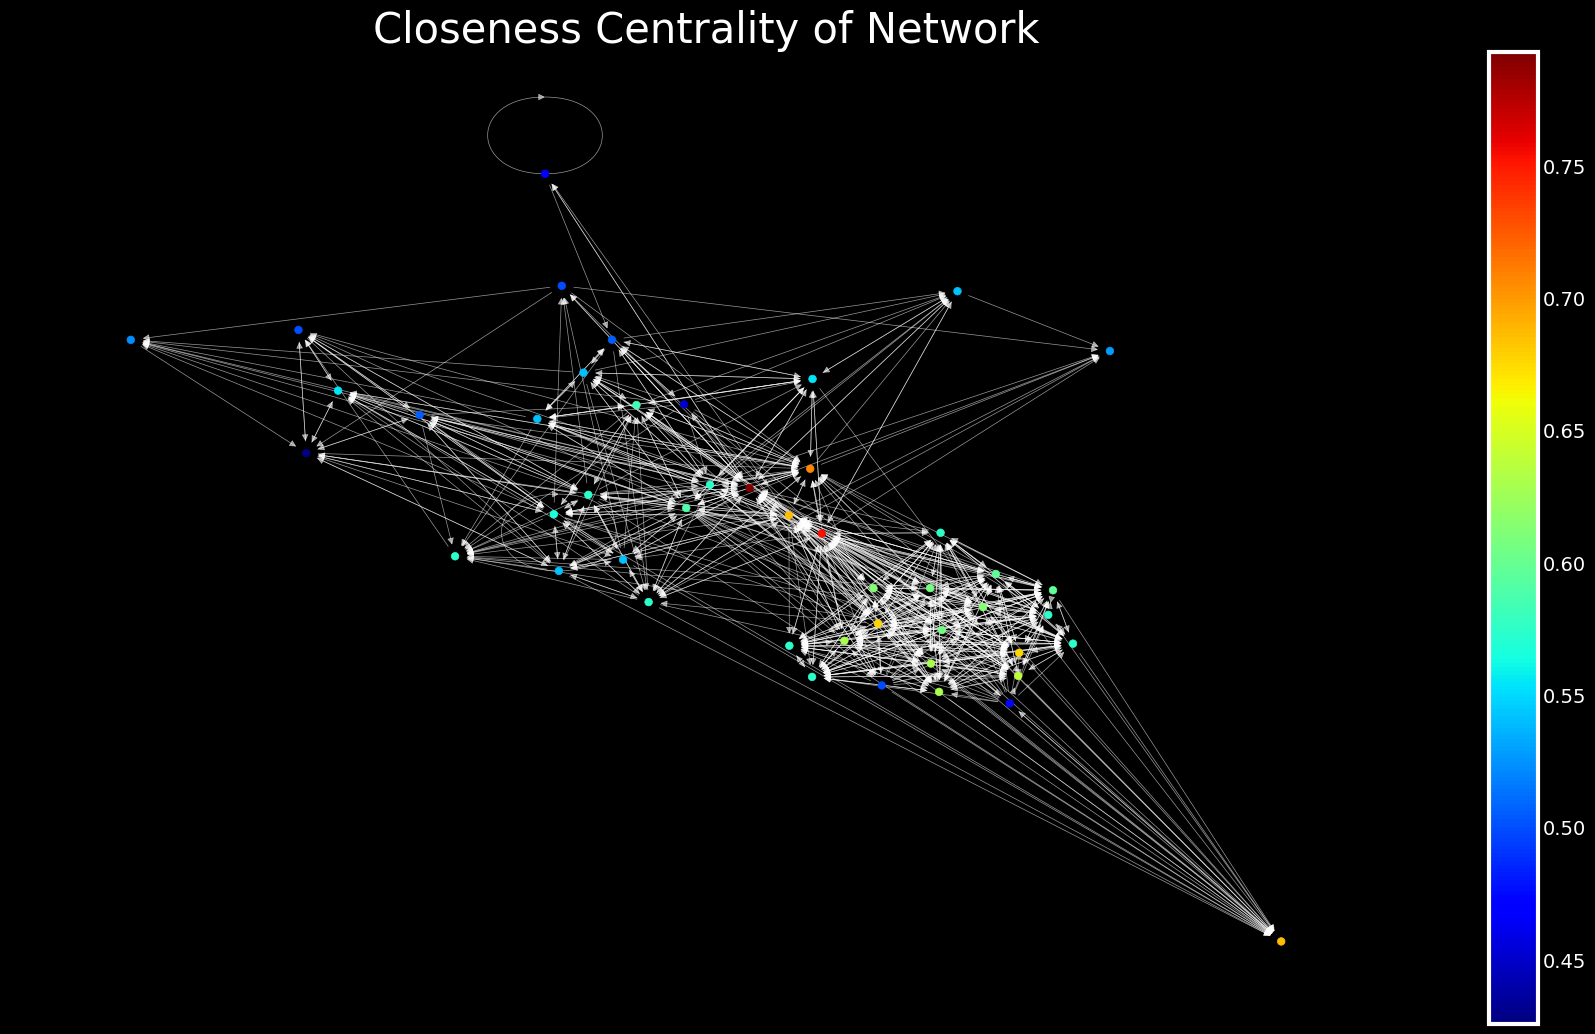

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

# the closeness centrality of network(Gcc)
fig, ax = plt.subplots(1,1,figsize=(20,12))

# layout position
#pos = nx.spring_layout(g,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.5,
                       alpha=0.6,
                       ax=ax,
                       edge_color='white')

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_closeness_centrality,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)

# draw labels
#nx.draw_networkx_labels(g, pos=pos,
#                        font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.title("Closeness Centrality of Network", fontsize = 30)
plt.savefig('closeness_centrality.jpg',dpi=300)
plt.show()

Closeness Centrality é a métrica que informa a distância média de todos os Nodes para um Node.

Se a métrica retornar um número pequeno, significa que um Node está longe dos outros Nodes. Por consequência, quanto maior o valor, mais próximo de todos os Nodes da network.

Essa métrica se torna interessante se você quer propagar uma informação, você pode enviar a esses Nodes que ela vai ser difundida mais rápido.

No plot vemos que na região central tem os Nodes com maior valor. Os que estão mais distantes do centro tem um valor de closeness menor, portanto são menos relevantes pro fluxo de transmissão da rede

In [ ]:
closeness_centrality = nx.closeness_centrality(Gcc)

Top 20 Nodes com maior valor de Closeness Centrality

In [ ]:
i=0
for k, v in sorted(closeness_centrality.items(), key=lambda x: x[1],reverse=True):
  print(k,v)
  if i == 20:
    break
  i+=1

International System Of Units 0.7931034482758621
Second 0.7540983606557377
Kilogram 0.7076923076923077
Centimetre–Gram–Second System Of Units 0.6865671641791045
Cgs Unit 0.6865671641791045
Gal (Unit) 0.6764705882352942
Centimetre 0.6764705882352942
Gauss (Unit) 0.6388888888888888
Abohm 0.6301369863013698
Barye 0.6301369863013698
Maxwell (Unit) 0.6301369863013698
Statampere 0.6133333333333333
Stilb (Unit) 0.6133333333333333
Abampere 0.6052631578947368
Abcoulomb 0.6052631578947368
Statvolt 0.5974025974025974
Abvolt 0.5974025974025974
System Of Measurement 0.5897435897435898
Conversion Of Units 0.5822784810126582
Abmho 0.575
Statmho 0.575


### 3.3 Betwenness Centrality

In [ ]:
# color of nodes
color_betweenness_centrality = list(dict(nx.betweenness_centrality(Gcc)).values())

In [ ]:
#joblib.dump(color_betweenness_centrality, 'color_betweenness_centrality.pkl')

In [ ]:
#color_betweenness_centrality = joblib.load('color_betweenness_centrality.pkl', mmap_mode='r')

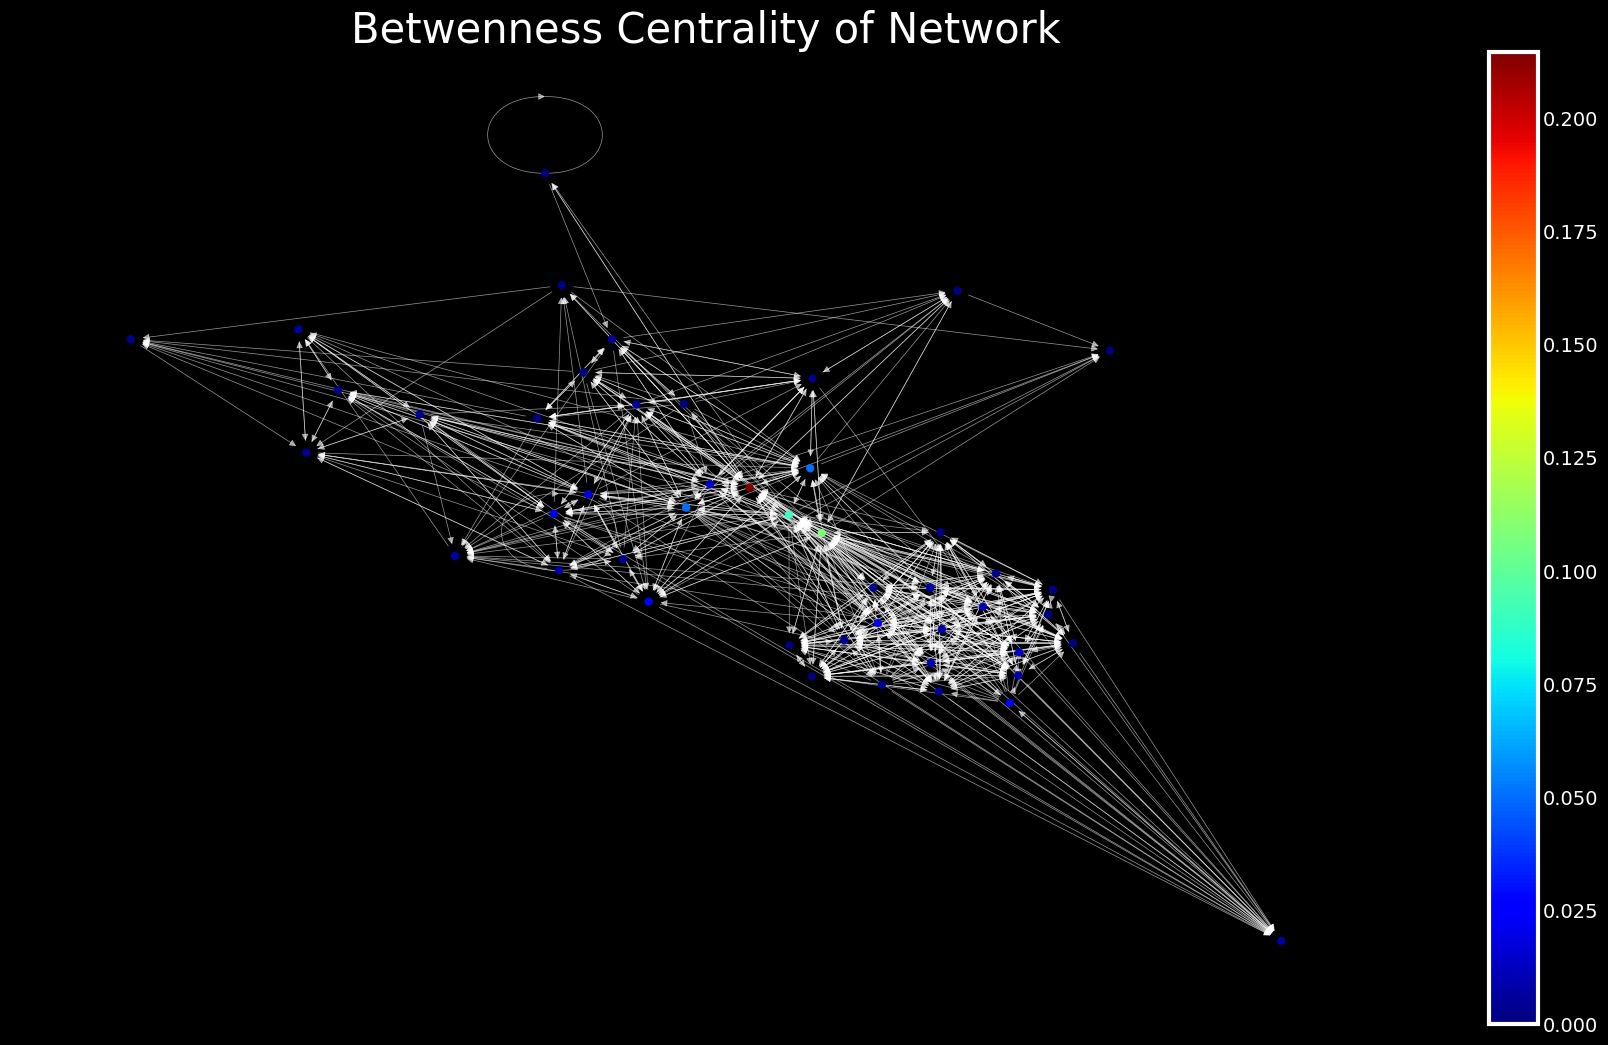

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

# the betwenness centrality of network(Gcc)
fig, ax = plt.subplots(1,1,figsize=(20,12))

# layout position
#pos = nx.spring_layout(g,seed=123456789,k=0.3)


# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.5,
                       alpha=0.6,
                       ax=ax,
                       edge_color='white')
# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_betweenness_centrality,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)
# draw labels
#nx.draw_networkx_labels(g, pos=pos,
#                        font_color='white', ax=ax)

plt.title("Betwenness Centrality of Network", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.savefig('betweenness_centrality.jpg', dpi=300)
plt.show()

O Betwenness Centrality informa a porcentagem de small paths (caminhos curtos) que um Node faz parte. Essa métrica da uma idéia de ponte. Se esse Node está sempre fazendo parte do fluxo da informação.

Quanto maior o valor, mais o Node é importante no fluxo da network. No plot vemos que existe um nó que se destaca muito mais que o restante, ele é importante para o fluxo da rede

In [ ]:
#Aqui tive que fazer uma improvisação. Essa métrica é muito custosa de calcular.
#Vamos aproveitar os valores achados no color
betweenness_centrality = {}
for node, value in zip(list(Gcc.nodes()),color_betweenness_centrality):
  betweenness_centrality[node] = value
#Ou você pode executar os códigos abaixo que vai trazer exatemente o mesmo resultado

In [ ]:
betweenness_centrality = nx.betweenness_centrality(Gcc)

Top 20 Nodes com maior Betwenness Centrality

In [ ]:
i=0
for k, v in sorted(betweenness_centrality.items(), key=lambda x: x[1],reverse=True):
  print(k,v)
  if i == 20:
    break
  i+=1

International System Of Units 0.2146635520810529
Second 0.1086174499434785
Centimetre–Gram–Second System Of Units 0.08939905760825909
System Of Measurement 0.05045239608084566
Kilogram 0.050332691162162296
Mks System Of Units 0.027246633783093818
Kayser (Unit) 0.023567596520495067
Centimetre 0.021801646215971065
United States Customary Units 0.02010420920762417
Imperial Units 0.019200485507649218
Metre 0.015279429571054071
Gal (Unit) 0.01357892740816951
Statampere 0.010610820853087908
Maxwell (Unit) 0.0098961395705795
Physical Unit 0.008107769553424491
Abampere 0.00785719766468211
Abcoulomb 0.00785719766468211
Cgs Unit 0.007680671448787391
Units Of Measurement In France Before The French Revolution 0.006934672658908603
Gauss (Unit) 0.006712911767786481
Conversion Of Units 0.005742783553117517


### 3.4 Eigenvector Centrality

In [ ]:
# color of nodes
color_eigenvector_centrality = list(dict(nx.eigenvector_centrality(Gcc)).values())

In [ ]:
#joblib.dump(color_eigenvector_centrality, 'color_eigenvector_centrality.pkl')

In [ ]:
#color_eigenvector_centrality = joblib.load('color_eigenvector_centrality.pkl', mmap_mode='r')

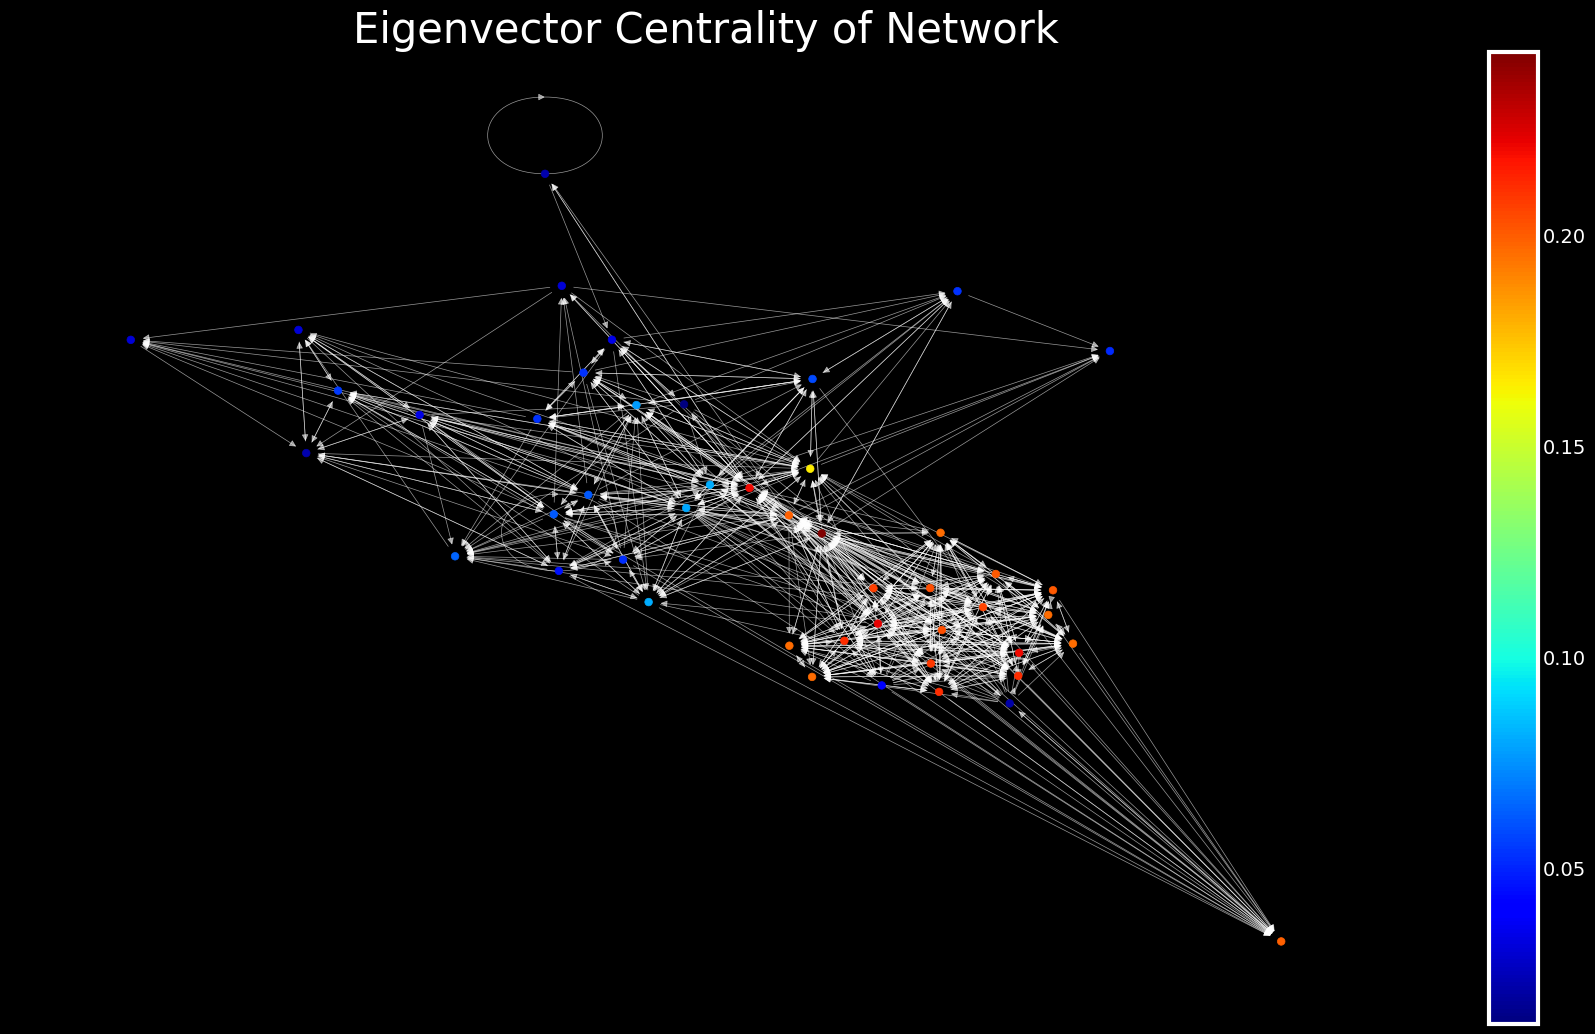

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

# the eigenvector centrality of network(Gcc)
fig, ax = plt.subplots(1,1,figsize=(20,12))

# layout position
#pos = nx.spring_layout(g,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.5,
                       alpha=0.6,
                       ax=ax,
                       edge_color='white')

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_eigenvector_centrality,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)

# draw labels
#nx.draw_networkx_labels(g, pos=pos,
#                        font_color='white', ax=ax)

plt.title("Eigenvector Centrality of Network", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.savefig('eigenvector_centrality.jpg',dpi=300)
plt.show()

Eigenvector (Auto-Vetor) Centrality verifica se um Node tem como vizinhos nós importantes. No plot temos uma região do grafo que tem uma importância muito maior para rede

In [ ]:
eigenvector_centrality = nx.eigenvector_centrality(Gcc)

Top 20 Nodes com maior Betwenness Centrality

In [ ]:
i=0
for k, v in sorted(eigenvector_centrality.items(), key=lambda x: x[1],reverse=True):
  print(k,v)
  if i == 20:
    break
  i+=1

Second 0.24348098252750222
Centimetre 0.22204736305279266
International System Of Units 0.2205244702282625
Gal (Unit) 0.22023304434788019
Gauss (Unit) 0.2118620685597948
Abohm 0.21121355255189894
Barye 0.21121355255189894
Maxwell (Unit) 0.2089889603880656
Stilb (Unit) 0.20728733649364106
Statampere 0.20618640295997323
Abcoulomb 0.20357767047427622
Abampere 0.2035776704742762
Statvolt 0.20036954912648755
Abvolt 0.20036954912648755
Centimetre–Gram–Second System Of Units 0.1990920272714938
Cgs Unit 0.1990920272714938
Abmho 0.19644333306822964
Statmho 0.19644333306822964
Abhenry 0.19644333306822964
Statohm 0.19644333306822964
Gilbert (Unit) 0.19644333306822964


### 3.5 All Together

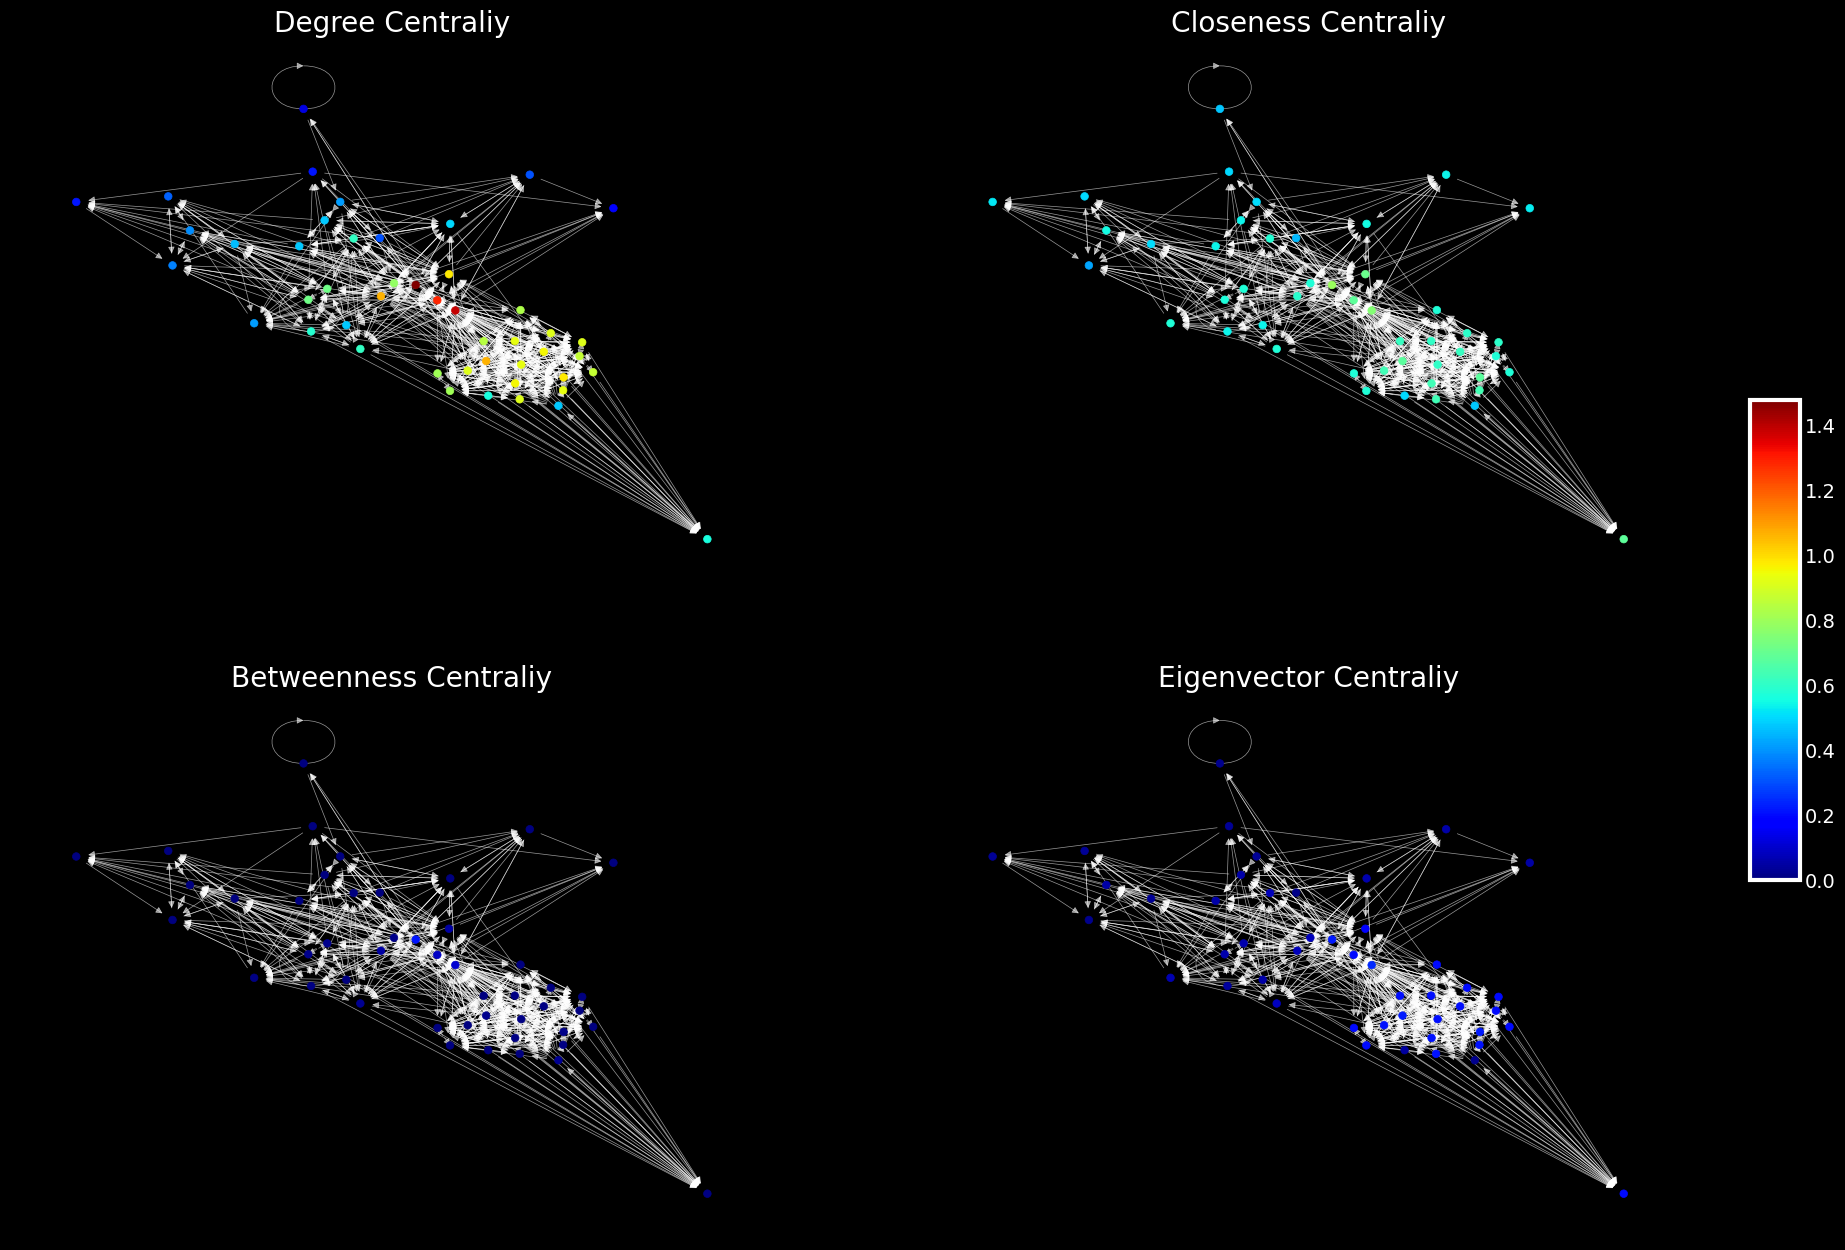

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

# the eigenvector centrality of network(g)
fig, ax = plt.subplots(2,2,figsize=(20,12))

# max value of metrics
max_centrality = max([max(color_betweenness_centrality),
                      max(color_closeness_centrality),
                      max(color_degree_centrality),
                      max(color_eigenvector_centrality)])

# layout position
#pos = nx.spring_layout(g,seed=123456789,k=0.3)


#
# draw edges
#
# degree centrality
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.5,
                       alpha=0.6,
                       ax=ax[0,0],
                       edge_color='white')

# closeness centrality
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.5,
                       alpha=0.6,
                       ax=ax[0,1],
                       edge_color='white')

# betweenness centrality
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.5,
                       alpha=0.6,
                       ax=ax[1,0],
                       edge_color='white')

# eigenvector centrality
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.5,
                       alpha=0.6,
                       ax=ax[1,1],
                       edge_color='white')

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_degree_centrality,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,0],
                 node_size=30)
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_closeness_centrality,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,1],
                 node_size=30)
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_betweenness_centrality,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,0],
                 node_size=30)
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_eigenvector_centrality,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,1],
                 node_size=30)

#
# draw labels
#
#nx.draw_networkx_labels(Gcc, pos=pos,
#                        font_color='white', ax=ax[0,0])
#nx.draw_networkx_labels(Gcc, pos=pos,
#                        font_color='white', ax=ax[0,1])
#nx.draw_networkx_labels(Gcc, pos=pos,
#                        font_color='white', ax=ax[1,0])
#nx.draw_networkx_labels(Gcc, pos=pos,
#                        font_color='white', ax=ax[1,1])

# eliminate axis
ax[0,0].axis("off")
ax[1,0].axis("off")
ax[0,1].axis("off")
ax[1,1].axis("off")

ax[0,0].set_title("Degree Centraliy")
ax[0,1].set_title("Closeness Centraliy")
ax[1,0].set_title("Betweenness Centraliy")
ax[1,1].set_title("Eigenvector Centraliy")


# Create an unique colorbar
# reference: https://stackoverflow.com/questions/60848582/unique-colorbar-at-the-right-of-multiple-subplots
plt.subplots_adjust(bottom=0., right=0.92, top=1.)
cax = plt.axes([0.95, 0.3, 0.025, 0.4])
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=max_centrality))
cbar=plt.colorbar(sm,cax)
plt.savefig('comparing_centrality_metrics.jpg',dpi=300,bbox_inches="tight")
plt.show()

## Step 4 | Multi Variate Analysis

In [ ]:
betweenness_centrality = {}
for node, value in zip(list(Gcc.nodes()),color_betweenness_centrality):
  betweenness_centrality[node] = value

closeness_centrality = {}
for node, value in zip(list(Gcc.nodes()),color_closeness_centrality):
  closeness_centrality[node] = value

eigenvector_centrality = {}
for node, value in zip(list(Gcc.nodes()),color_eigenvector_centrality):
  eigenvector_centrality[node] = value

degree_centrality = {}
for node, value in zip(list(Gcc.nodes()),color_degree_centrality):
  degree_centrality[node] = value

In [ ]:
import pandas as pd

In [ ]:
df_mva = pd.DataFrame.from_dict({"Betweenness": betweenness_centrality,
                            "Degree": degree_centrality,
                            "EigenVector": eigenvector_centrality,
                            "Closeness": closeness_centrality})
df_mva.reset_index(inplace=True,drop=True)
df_mva.head()

Betweenness    Degree  EigenVector  Closeness
0     0.000000  0.804348     0.196443   0.575000
1     0.003402  0.913043     0.211214   0.630137
2     0.000000  0.804348     0.196443   0.575000
3     0.006713  0.934783     0.211862   0.638889
4     0.007857  0.934783     0.203578   0.605263

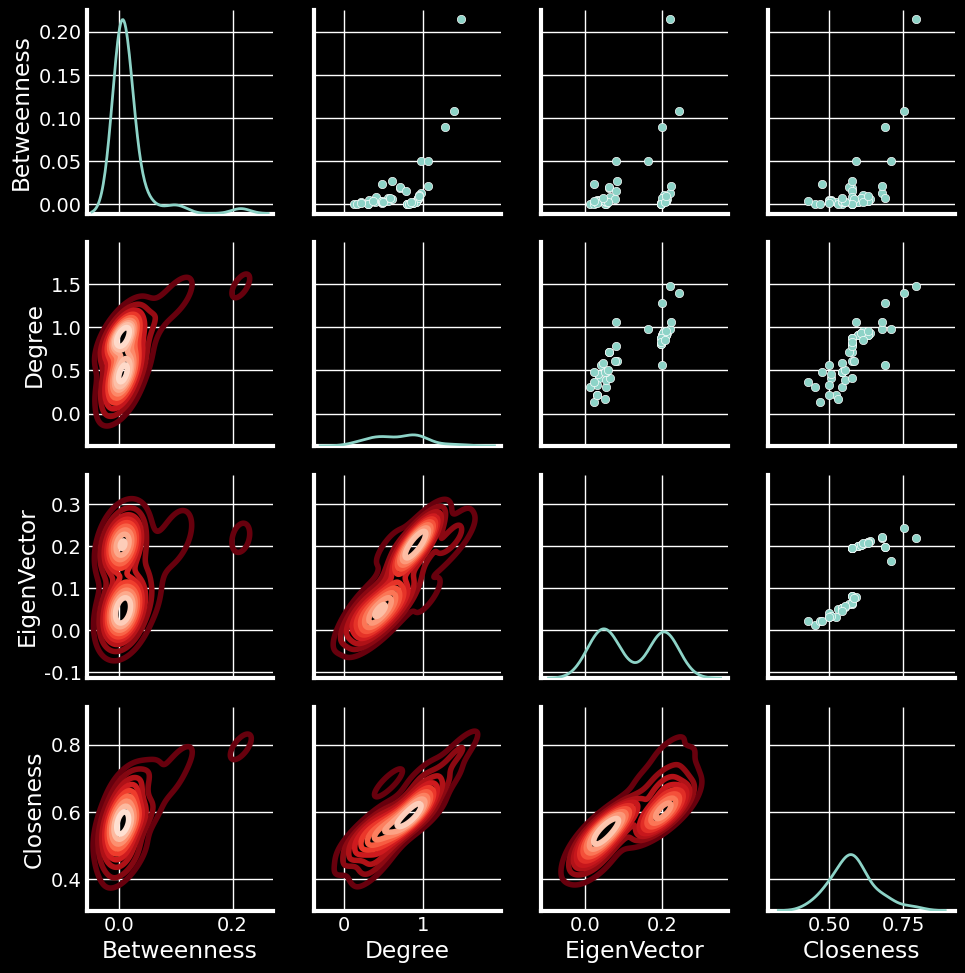

In [ ]:
fig = sns.PairGrid(df_mva)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap="Reds_r")
fig.map_diag(sns.kdeplot, lw=2, legend=False)

plt.savefig('multivariate_analysis.jpg', dpi=300,bbox_inches="tight")
plt.show()

Na PDF [1,1] mostra uma grande quantidade de Nodes com baixo Betwenness. Poucos Nodes com um valor um pouco superior. Expõe os Hubs da network. Das outras três PDF de Degree [2,2], EigenVector [3,3] e Closeness [4,4], apenas Closeness tem relevância, sendo a maioria dos nós concentrada em cerca de 0.6.

Em [1,2] quando eu tenho um aumento no Degree, também é aumentada o Betwenness. Logo, quando eu atinjo um certo número de Degree ele passa a ser mais importante para o fluxo da network.

Em [1,3] e [1,4] esse formato de aumento de Betwenness é bem semelhante.

Em [2,3] quando eu tenho um crescimento do EigenVector, o Degree acaba crescendo de forma linear. Ou seja, quando mais um Node tem vizinhos importantes, mais vizinhos ele vai tendo.


Já em [2,4], o Degree tem um ganho quando o Closeness supera o valor de 0.5. Após ele atingir um alto valor de proximidade a todos os Nodes, ele passa a ter um ganho de Degree.

Esse mesmo movimento de crescimento visto em [2,4] é repetido para [3,4]. Quando a proximidade aumenta, ele passa a ter muitos vizinhos importantes. Os outros são apenas a mesma representação só que no formado do KDE bivariado.

## Step 5 | Core Decomposition

### K-Core and K-Shell

O K-Core de um grafo é o subgrafo máximo tal que todo vértice tem grau de pelo menos k. O K-Shell é o conjunto de vértices que fazem parte do K-Core, mas não fazem parte do (K +1)-Core. Ela nos permite visualizar quem está no núcleo da network. (https://www.johndcook.com/blog/2016/01/25/understanding-a-graph-by-peeling-away-nodes/)



Funcionamento: É um método iterativo. A cada iteração ele verifica o grau dos Nodes, se for igual ao valor da iteração é retirado da rede. Se, ao retirar um Node o vizinho dele passar a ser do grau da iteração, ele também vai ser removido.

Ao termino das remoções, teremos o N-Shell que foram nos Nodes removidos. O algoritmo termina quando a iteração atinge o valor suficiente que eliminaria todos os Nodes.

Em resumo, o K-Core vai ser Nodes pós remoção, e o (K-1)-Shell será os Nodes do K-Core mais os removidos dessa iteração

Essa análise não permite selfloops

In [ ]:
# Criar uma cópia modificável do GCC
gcc_copy = Gcc.copy()

# Remover self-loops da cópia
gcc_copy.remove_edges_from(nx.selfloop_edges(gcc_copy))

Temos 12 k-cores

In [ ]:
len(set([v for k,v in nx.core_number(gcc_copy).items()]))

12

O máximo valor também é 34. Logo varia de 1 - 34

In [ ]:
max(set([v for k,v in nx.core_number(gcc_copy).items()]))

34

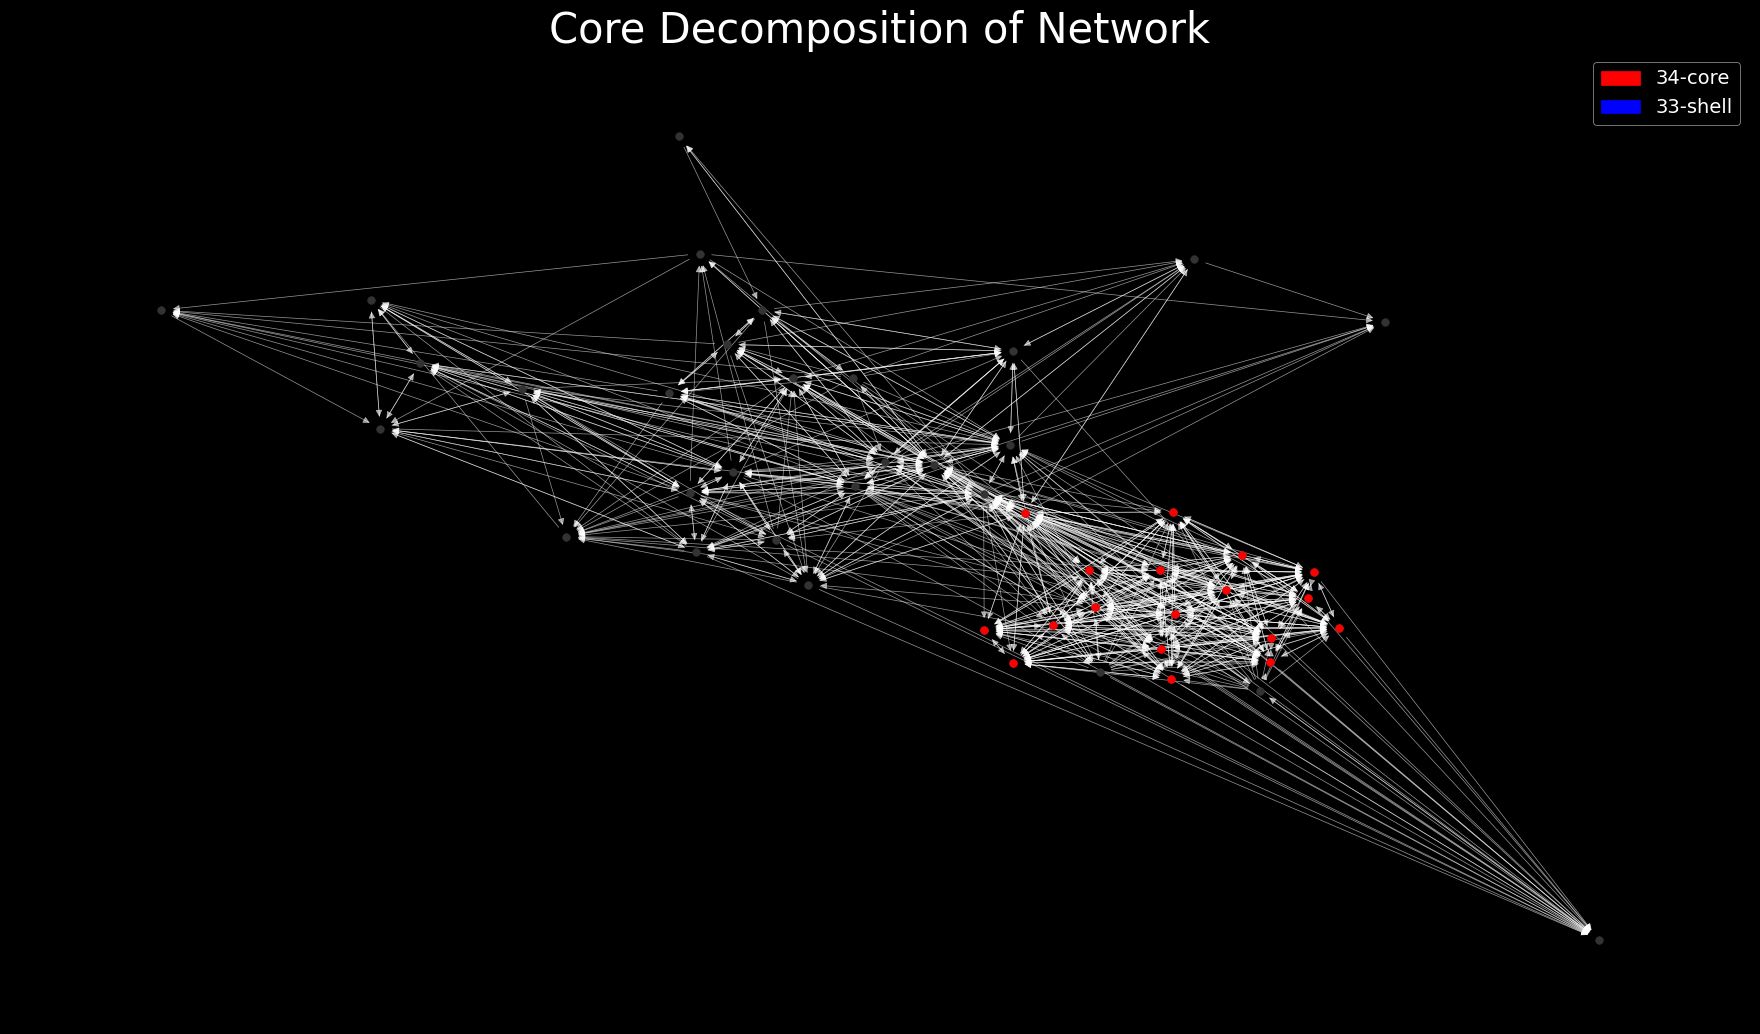

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

fig, ax = plt.subplots(1,1,figsize=(20,12))

# Find k-cores
Gcc_core_33 = nx.k_shell(gcc_copy, 33)
Gcc_core_34 = nx.k_core(gcc_copy, 34)

# layout position
#pos = nx.spring_layout(g2,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(gcc_copy,
                       pos=pos,
                       width=0.5,
                       alpha=0.6,
                       ax=ax,
                       edge_color='white')

# draw nodes
nodes = nx.draw_networkx_nodes(gcc_copy,
                 pos=pos,
                 node_color="#333333",
                 ax=ax,
                 node_size=30)

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc_core_33,
                 pos=pos,
                 node_color="blue",
                 ax=ax,
                 node_size=30)

nodes = nx.draw_networkx_nodes(Gcc_core_34,
                 pos=pos,
                 node_color="red",
                 ax=ax,
                 node_size=30)

# static legend
blue_patch = mpatches.Patch(color='blue', label='33-shell')
red_patch = mpatches.Patch(color='red', label='34-core')
plt.legend(handles=[red_patch,blue_patch])
plt.title("Core Decomposition of Network", fontsize = 30)
plt.axis("off")
plt.savefig('core-decomposition.jpg',dpi=300)
plt.show()

Nosso GCC tem 34 níveis até chegar o núcleo da network. Eles estão concentrados no centro do grafo. Possível visualizar alguns Nodes do K-Shell.

In [ ]:
K_core = set(nx.k_core(gcc_copy,34))

In [ ]:
K_shell = set(nx.k_shell(gcc_copy,33))

In [ ]:
len(K_shell),len(K_core)

(0, 18)

Os Nodes que foram removidos no último nível

In [ ]:
for i in K_shell:
  print(i)

Os Nodes pertencentes ao Núcleo da rede. Cada um deles contendo pelo menos 34 vizinhos

In [ ]:
for i in K_core:
  print(i)

Abmho
Abohm
Statmho
Gauss (Unit)
Abampere
Abcoulomb
Statohm
Centimetre
Abhenry
Gilbert (Unit)
Statvolt
Barye
Stilb (Unit)
Gal (Unit)
Maxwell (Unit)
Second
Statampere
Abvolt


### GCC vs K-Core

In [ ]:
color_degree_k_core_34 = list(dict(nx.degree(nx.k_core(gcc_copy,34))).values())

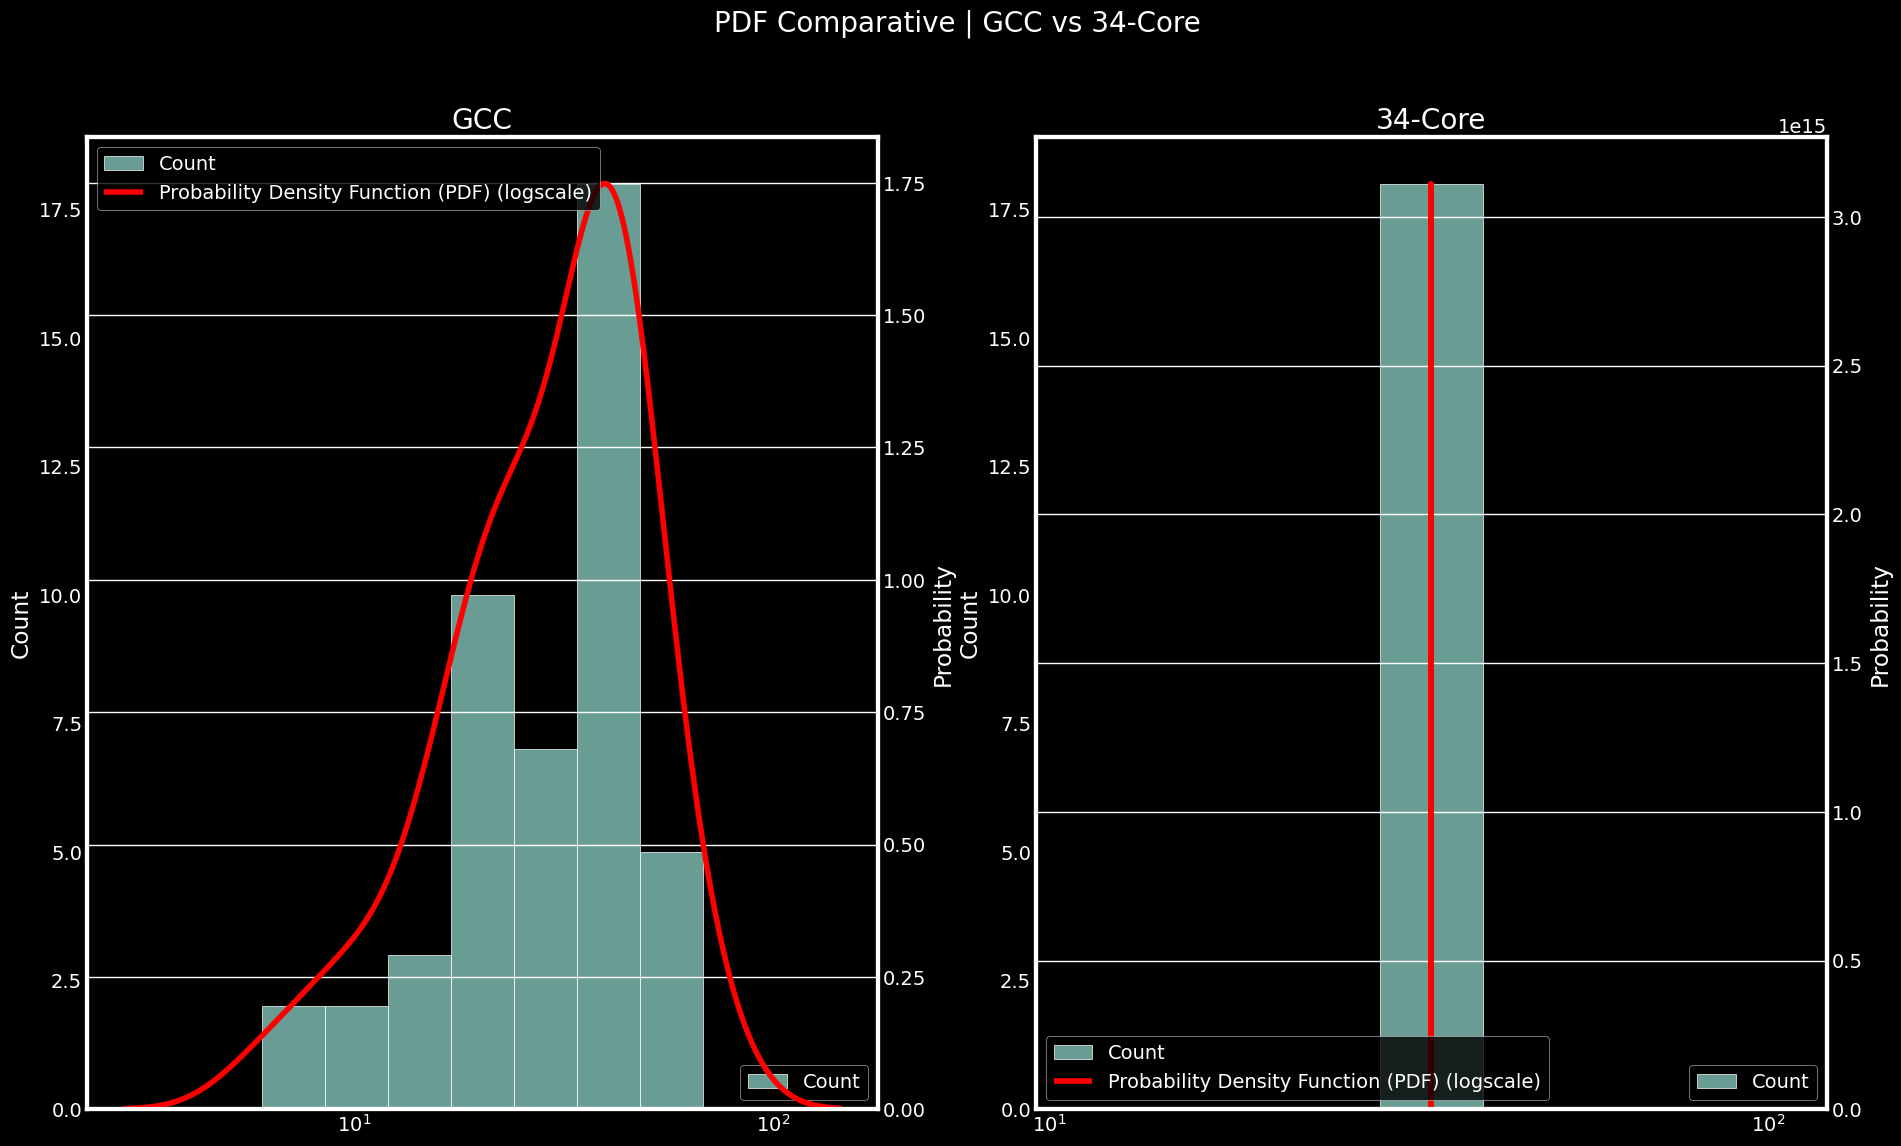

In [ ]:
plt.style.use("dark_background")
fig, ax = plt.subplots(1,2,figsize=(20,12))

sns.histplot(color_degree,label="Count",ax=ax[0],bins=7,log_scale=True)
ax2 = ax[0].twinx()
sns.kdeplot(color_degree,color='r',label="Probability Density Function (PDF) (logscale)",ax=ax2)
ax[0].grid(False)
ax[0].legend(loc="lower right")
ax[0].set_ylabel("Count")

sns.histplot(color_degree_k_core_34,label="Count",ax=ax[1],bins=7,log_scale=True)
ax3 = ax[1].twinx()
sns.kdeplot(color_degree_k_core_34,color='r',label="Probability Density Function (PDF) (logscale)",ax=ax3)
ax[1].grid(False)
ax[1].set_ylabel("Count")
ax[1].legend(loc="lower right")


# ask matplotlib for the plotted objects and their labels
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

lines3, labels3 = ax[1].get_legend_handles_labels()
lines4, labels4 = ax2.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc=0)

ax[0].title.set_text('GCC')
ax[1].title.set_text('34-Core')

ax2.set_ylabel("Probability")
ax3.set_ylabel("Probability")

plt.title("PDF Comparative | GCC vs 34-Core", fontsize = 20, x=-0.1, y=1.1)
plt.savefig('comparative-pdf-gcc-kcore.jpg', dpi=300,bbox_inches="tight")
plt.show()

Como falado anteriormente, o uso de escala Log permite comparar networks com tamanhos diferentes. Na distribuição do 34-Core o núcleo da rede não segue o padrão obtido na GCC. Enquanto a GCC tem o formato de uma Gaussiana (estão concentrados Nodes em torno da mediana apesar de um pouco deslocado a esquerda), a 34-Core
está totalmente concentrada em torno da média. Um bom exercício seria descobrir qual foi o K-Core que fez a distribuição ficar similar a GCC

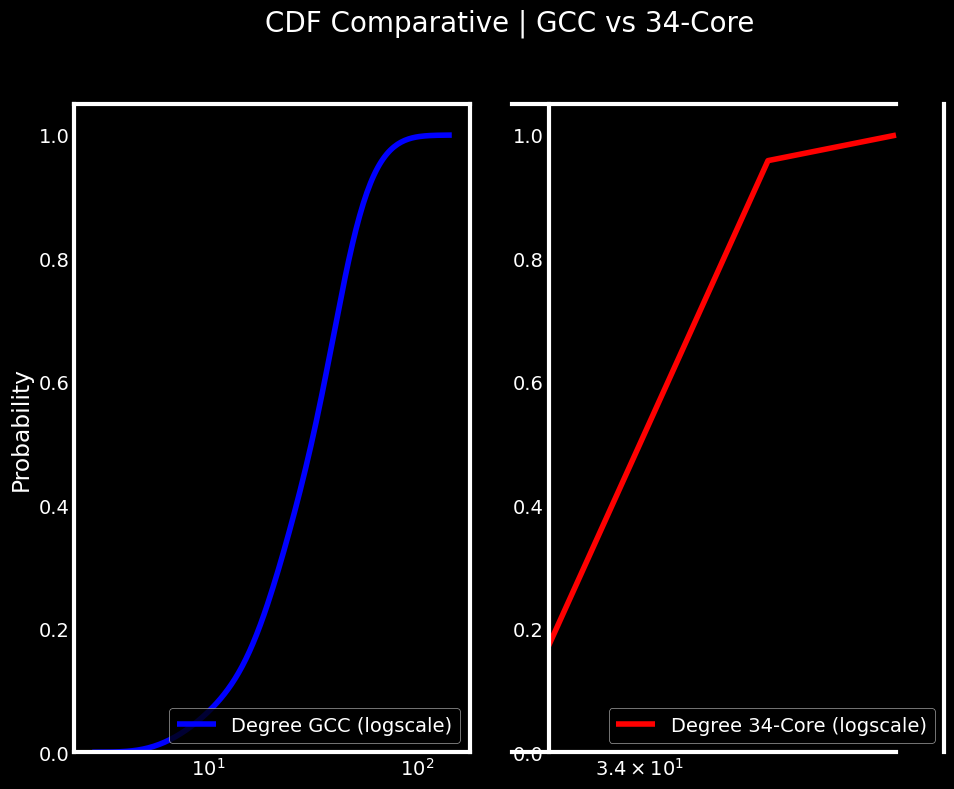

In [ ]:
plt.style.use("dark_background")
fig, ax = plt.subplots(1,2,figsize=(10,8))

sns.kdeplot(color_degree,color='b',label="Degree GCC (logscale)",ax=ax[0],cumulative=True,log_scale=True)
ax[0].grid(False)
ax[0].legend(loc="lower right")
ax[0].set_ylabel("Probability")

sns.kdeplot(color_degree_k_core_34,color='r',label="Degree 34-Core (logscale)",ax=ax[1],cumulative=True,log_scale=True)
ax[1].grid(False)
ax[1].set_ylabel("")
ax[1].legend(loc="lower right")

plt.title("CDF Comparative | GCC vs 34-Core", fontsize = 20, x=-0.1, y=1.1)
plt.savefig('comparative_cdf_core_decomposition_log.jpg', dpi=300,bbox_inches="tight")
plt.show()

A CDF são bastantes parecidas, a 34-Core acaba sendo um pouco mais linear. Ambas atingindo o total de Nodes quase próximas a última